<a href="https://colab.research.google.com/github/aadityakhant/fakeNewsDetection/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*" --quiet
!pip install -q -U tf-models-official==2.7.0 --quiet
!pip install -U tfds-nightly --quiet

from IPython.display import clear_output
clear_output()

In [ ]:
from IPython.display import HTML, display
def progress(value, max=200):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
import os
import csv
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
clear_output()

In [ ]:
tf.get_logger().setLevel('ERROR')
out = display(progress(0, 200), display_id=True)

def make_bert_preprocess_model(sentence_features, seq_length=128):

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  truncated_segments = [tokenizer(s) for s in input_segments]
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['title', 'content'])

def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

def data_loader(l, r, length, bert_preprocess_model):
  classes = {'fake':0, 'clickbait':1, 'valid':2, 'bias':3}
  news={'input_mask':[], 'input_type_ids':[], 'input_word_ids':[]}
  labels = []
  for i in range(l,r):
      out.update(progress(i, 200))
      file = open('./drive/MyDrive/data2/pickle-'+str(i)+'.csv', 'r', encoding='latin-1')
      reader = csv.reader(file)
      for r in reader:
        pre = bert_preprocess_model([np.array([r[0]]), np.array([r[1]])])
        news['input_mask'].append(pre['input_mask'])
        news['input_type_ids'].append(pre['input_type_ids'])
        news['input_word_ids'].append(pre['input_word_ids'])
        labels.append(classes[r[2]])
      file.close()
  news['input_mask'] = tf.reshape(news['input_mask'], (length, 128))
  news['input_type_ids'] = tf.reshape(news['input_type_ids'], (length, 128))
  news['input_word_ids'] = tf.reshape(news['input_word_ids'], (length, 128))
  return (news,labels)

news_train = data_loader(0,200,100000,bert_preprocess_model)
news_valid = data_loader(200,210,5000,bert_preprocess_model)

def load_dataset_from_tfds(in_memory_ds, train, batch_size, ):
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds)
  if train:
    dataset = dataset.shuffle(len(dataset))
  dataset = dataset.batch(batch_size)
  dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


In [ ]:
epochs = 1
batch_size = 32
init_lr = 2e-5

train_dataset = load_dataset_from_tfds(news_train, train=True, batch_size=batch_size)
steps_per_epoch = 100000 // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

validation_dataset = load_dataset_from_tfds(news_valid, train=False, batch_size=batch_size, )
validation_steps = 5000 // batch_size

metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier_model = build_classifier_model(4)

optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

checkpoint_path = "./drive/MyDrive/bert/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
classifier_model.load_weights("./drive/MyDrive/bert/cp.ckpt")

In [ ]:
classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps,
      callbacks=[cp_callback])

2542/3125 [=======================>......] - ETA: 1:26:14 - loss: 0.6821 - accuracy: 0.7162

In [ ]:
news_test = data_loader(360,400,20000,bert_preprocess_model)

In [ ]:
test_dataset = load_dataset_from_tfds(news_test, train=False, batch_size=batch_size)

In [ ]:
y_pred = classifier_model.predict(test_dataset)

In [ ]:
y_p = [np.argmax(i) for i in y_pred]

In [ ]:
y_t = news_test[1]

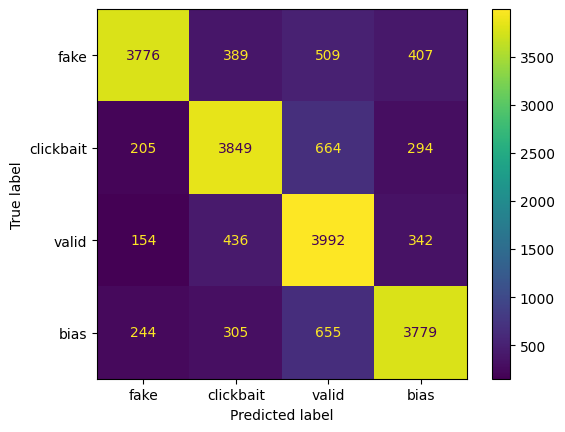

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay(confusion_matrix(y_t, y_p), display_labels=['fake','clickbait','valid','bias']).plot()
plt.show()

In [ ]:
print(classification_report(y_pred=y_p, y_true=y_t))

              precision    recall  f1-score   support

           0       0.86      0.74      0.80      5081
           1       0.77      0.77      0.77      5012
           2       0.69      0.81      0.74      4924
           3       0.78      0.76      0.77      4983

    accuracy                           0.77     20000
   macro avg       0.78      0.77      0.77     20000
weighted avg       0.78      0.77      0.77     20000

